In [1]:
# imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('dark')

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.modeling import modeling_functions as mf

In [2]:
codes = pd.read_csv('../EXTR_LookUp.csv')

In [3]:
df = pd.read_csv('../leana_m2')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,documentdate,saleprice,propertytype,principaluse,saleinstrument,currentuseland,historicproperty,salereason,propertyclass,zipcode,...,z_wtfnt_3,z_wtfnt_4,ctr_saleprice,ctr_squarefeettotalliving,ctr_bathtotcount,ctr_squarefeetdeck,ctr_sqftporch,ctr_wtfnt_2,ctr_wtfnt_3,ctr_wtfnt_4
0,2019-04-01,1065000.0,12,6,3,N,N,1,8,98102.0,...,-0.034015,-0.014838,331373.499725,617.536819,0.592488,-130.497468,18.247716,-0.003687,-0.001156,-0.00022
1,2019-05-04,890000.0,12,6,3,N,N,1,8,98011.0,...,-0.034015,-0.014838,156373.499725,1077.536819,2.342488,-40.497468,-21.752284,-0.003687,-0.001156,-0.00022
2,2019-11-05,640000.0,11,6,3,N,N,1,8,98125.0,...,-0.034015,-0.014838,-93626.500275,-582.463181,-0.407512,279.502532,-21.752284,-0.003687,-0.001156,-0.00022
3,2019-01-25,645000.0,11,6,3,N,N,1,8,98028.0,...,-0.034015,-0.014838,-88626.500275,-32.463181,-0.407512,129.502532,-71.752284,-0.003687,-0.001156,-0.00022
4,2019-10-05,907000.0,11,6,3,N,N,1,8,98005.0,...,-0.034015,-0.014838,173373.499725,177.536819,0.342488,179.502532,-71.752284,-0.003687,-0.001156,-0.00022


# Model Iterations - take 3

In this notebook, we continue to iterate and explore other features which might be explaining sale price.  Our current best r^2 value is 0.3717 from model 7 in the ll_latenight notebook.  This model was created using `saleprice ~ sqft_ctr + baths_ctr + tot_basement_ctr + deck_ctr + porch_ctr` 

**note:** 
- these features are named differently in this current df
- In luluva's model she included square foot basement count where as I remove it from the model fearing it will be double counted.

To recap, that model looked like this:

In [4]:
x_features7 = ['ctr_squarefeettotalliving', 'ctr_bathtotcount', 'ctr_squarefeetdeck', 'ctr_sqftporch']

In [5]:
features7 = ['saleprice', 'ctr_squarefeettotalliving', 'ctr_bathtotcount', 'ctr_squarefeetdeck', 'ctr_sqftporch']

In [6]:
model7 = mf.model(features7, df, 'saleprice')

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2619.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:32:09   Log-Likelihood:            -2.5454e+05
No. Observations:               18170   AIC:                         5.091e+05
Df Residuals:                   18165   BIC:                         5.091e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

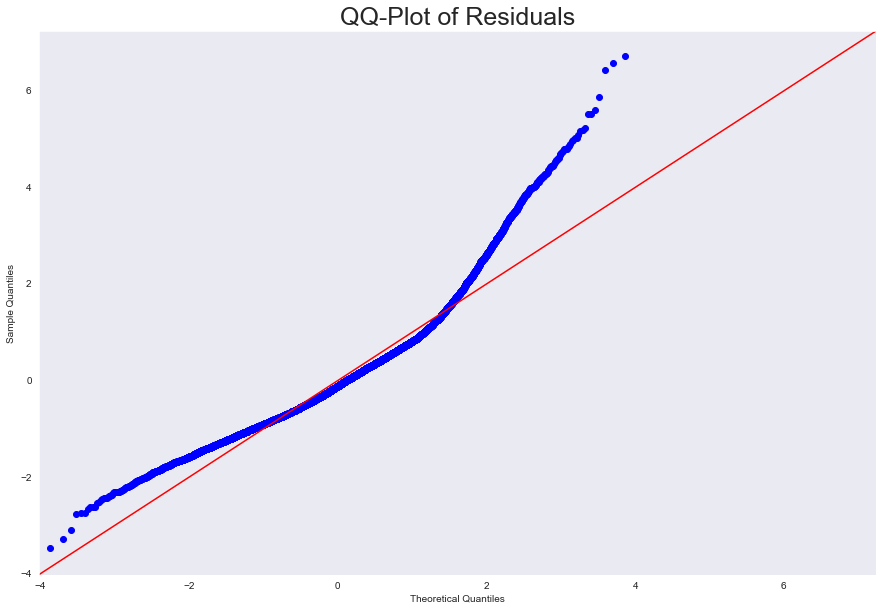

In [7]:
mf.normality_assumption(model7)

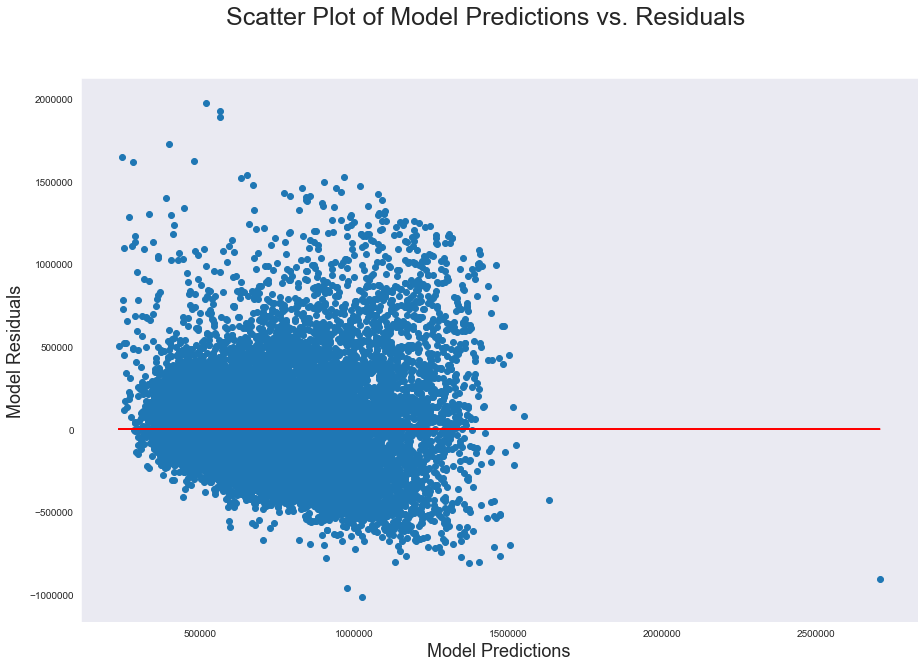

In [8]:
mf.homo_assumption(model7, df)

Show multicollinearity for these features:

In [9]:
df_x_feats = df.loc[:, x_features7]

In [10]:
df_x_feats.head()

,ctr_squarefeettotalliving,ctr_bathtotcount,ctr_squarefeetdeck,ctr_sqftporch
0,617.536819,0.592488,-130.497468,18.247716
1,1077.536819,2.342488,-40.497468,-21.752284
2,-582.463181,-0.407512,279.502532,-21.752284
3,-32.463181,-0.407512,129.502532,-71.752284
4,177.536819,0.342488,179.502532,-71.752284


In [11]:
x_corrs = df_x_feats.corr()

Text(0.5, 1, 'Heat Map of Feature Multicollinearity')

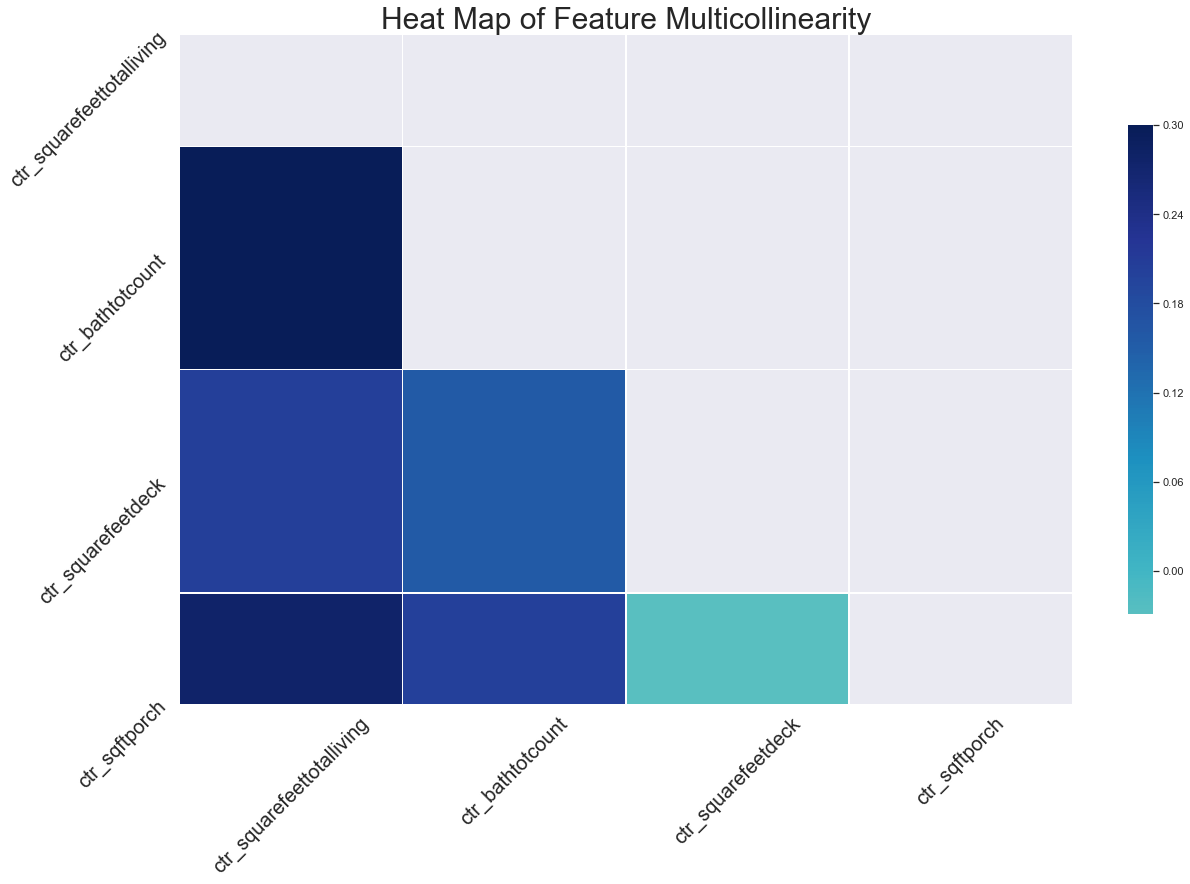

In [12]:
mask = np.triu(np.ones_like(x_corrs, dtype=np.bool))
f, ax = plt.subplots(figsize = (20, 18))
sns.heatmap(x_corrs, mask = mask, cmap="YlGnBu", vmax = 0.3, 
            center = 0, square = True, linewidths = 0.5, 
            cbar_kws = {'shrink': 0.5})
ax.tick_params(axis='both', which='major', labelsize=20, labelrotation = 45)
ax.set_title('Heat Map of Feature Multicollinearity', fontsize = 30)

Here we see that there is some multicollinearity betewen the total square feet and the bathroom count as well as the total square living and porch square footage.  Note that the max scale is 0.3 for the highest correlations so it is super high.  

Let's take another look at our highest correlations with sale price to see what feature we should try adding next:

In [13]:
data_corrs = df.corr()

# inspect all the correlations with 'saleprice' in descedning order so we can see highest correlations
sorted_corrs = data_corrs['saleprice'].sort_values(ascending = False)

high_corrs = sorted_corrs[sorted_corrs > 0.1]
high_corrs

z_saleprice                  1.000000
ctr_saleprice                1.000000
saleprice                    1.000000
buildinggrade                0.616610
ctr_squarefeettotalliving    0.596667
squarefeettotalliving        0.596667
z_totsqft                    0.596667
z_totbath                    0.462755
ctr_bathtotcount             0.462755
bathtotcount                 0.462755
township                     0.460701
bathfullcount                0.314642
stories                      0.291929
bedrooms                     0.285476
viewseattleskyline           0.240973
squarefeettotalbasement      0.224920
squarefeetopenporch          0.206728
has_porch                    0.203582
ctr_squarefeetdeck           0.202791
squarefeetdeck               0.202791
z_squarefeetdeck             0.202791
ctr_sqftporch                0.202770
sqftporch                    0.202770
z_sqftporch                  0.202770
viewlakesammamish            0.186923
fireplacemultiplestory       0.182090
bath3qtrcoun

From this, let's look at adding building grade to our model.

## Model 12

In this model we add building grade to our model.

In [14]:
df['buildinggrade'].unique()

array([ 8,  7,  6, 10,  9, 11,  5, 12,  4,  1,  3])

In [15]:
df.buildinggrade.dtype

dtype('int64')

It seems like `buildingrade` is more likely to be a categorical variable.  Let's look up the look up codes to see what these values represent:

In [16]:
codes[codes['LUType'] == 82]['LUDescription']

1150    1  Cabin                                      ...
1151    10 Very Good                                  ...
1152    11 Excellent                                  ...
1153    12 Luxury                                     ...
1154    13 Mansion                                    ...
1155    2  Substandard                                ...
1156    Exceptional Properties                        ...
1157    3  Poor                                       ...
1158    4  Low                                        ...
1159    5  Fair                                       ...
1160    6  Low Average                                ...
1161    7  Average                                    ...
1162    8  Good                                       ...
1163    9  Better                                     ...
Name: LUDescription, dtype: object

Let's view a plot between this and sale price:

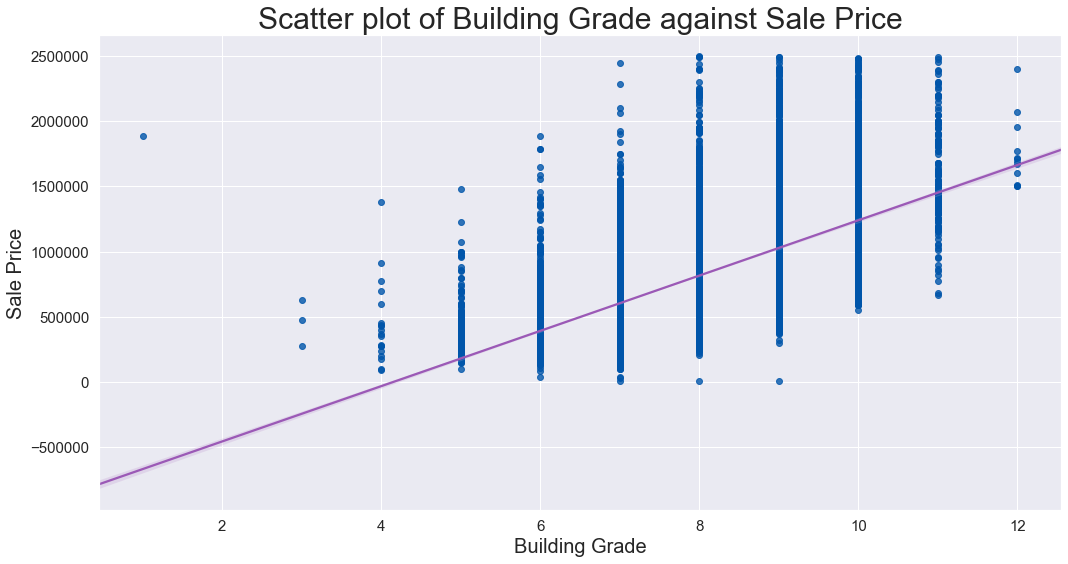

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
sns.regplot(x = 'buildinggrade', y = 'saleprice', data = df, scatter_kws={"color": "#0055AA"}, line_kws={"color": "#9b59b6"});
ax.set_title('Scatter plot of Building Grade against Sale Price', fontsize = 30)
ax.tick_params(axis='both', labelsize=15)
plt.xlabel('Building Grade', fontsize = 20)
plt.ylabel('Sale Price', fontsize = 20)
plt.tight_layout()

We can see this has a strong linear relationship.  Let's dummy out the variables so we can use them for our model.

In [18]:
df['buildinggrade'] = df['buildinggrade'].astype('category')

In [19]:
df.buildinggrade.dtype

CategoricalDtype(categories=[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=False)

In [20]:
# create dummies
buildgrade_dummies = pd.get_dummies(df['buildinggrade'], prefix='bldgr', drop_first=True)

In [37]:
# drop existing buildinggrade variable to be replaced by dummies
df = df.drop('buildinggrade', axis=1)

In [21]:
df = pd.concat([df, buildgrade_dummies], axis=1)

In [22]:
df.head()

,documentdate,saleprice,propertytype,principaluse,saleinstrument,currentuseland,historicproperty,salereason,propertyclass,zipcode,...,bldgr_3,bldgr_4,bldgr_5,bldgr_6,bldgr_7,bldgr_8,bldgr_9,bldgr_10,bldgr_11,bldgr_12
0,2019-04-01,1065000.0,12,6,3,N,N,1,8,98102.0,...,0,0,0,0,0,1,0,0,0,0
1,2019-05-04,890000.0,12,6,3,N,N,1,8,98011.0,...,0,0,0,0,1,0,0,0,0,0
2,2019-11-05,640000.0,11,6,3,N,N,1,8,98125.0,...,0,0,0,0,1,0,0,0,0,0
3,2019-01-25,645000.0,11,6,3,N,N,1,8,98028.0,...,0,0,0,0,1,0,0,0,0,0
4,2019-10-05,907000.0,11,6,3,N,N,1,8,98005.0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
# Use our same features from previous model and add building grades - note we use ctr of the variables because they had higher correlations
build_cols = []
for column in df.columns:
    if column.startswith('bldgr'):
        build_cols.append(column)
        
features12 = ['saleprice', 'ctr_squarefeettotalliving', 'ctr_bathtotcount', 'ctr_squarefeetdeck', 'ctr_sqftporch'] + build_cols

In [24]:
model12 = mf.model(features12, df, 'saleprice')

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     1100.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:32:40   Log-Likelihood:            -2.5310e+05
No. Observations:               18170   AIC:                         5.062e+05
Df Residuals:                   18155   BIC:                         5.063e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

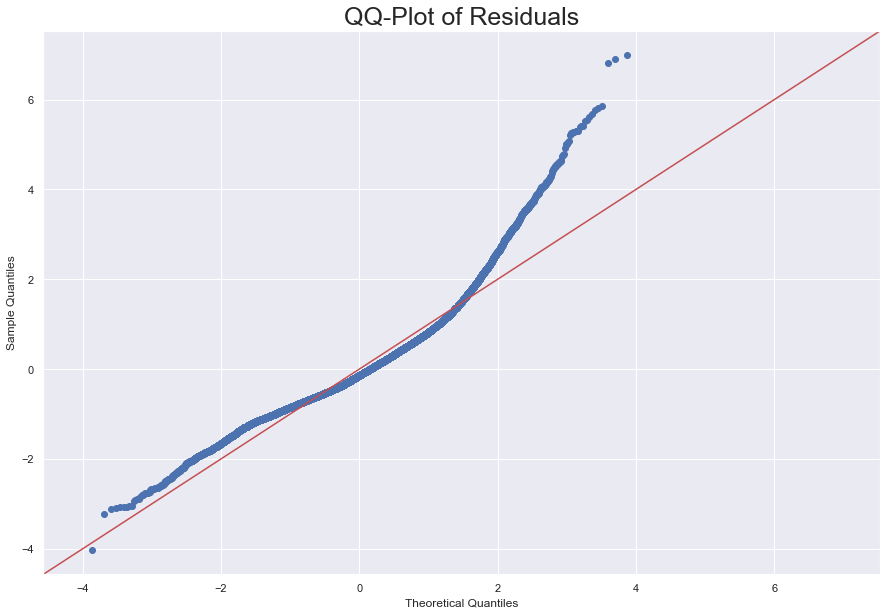

In [25]:
mf.normality_assumption(model12)

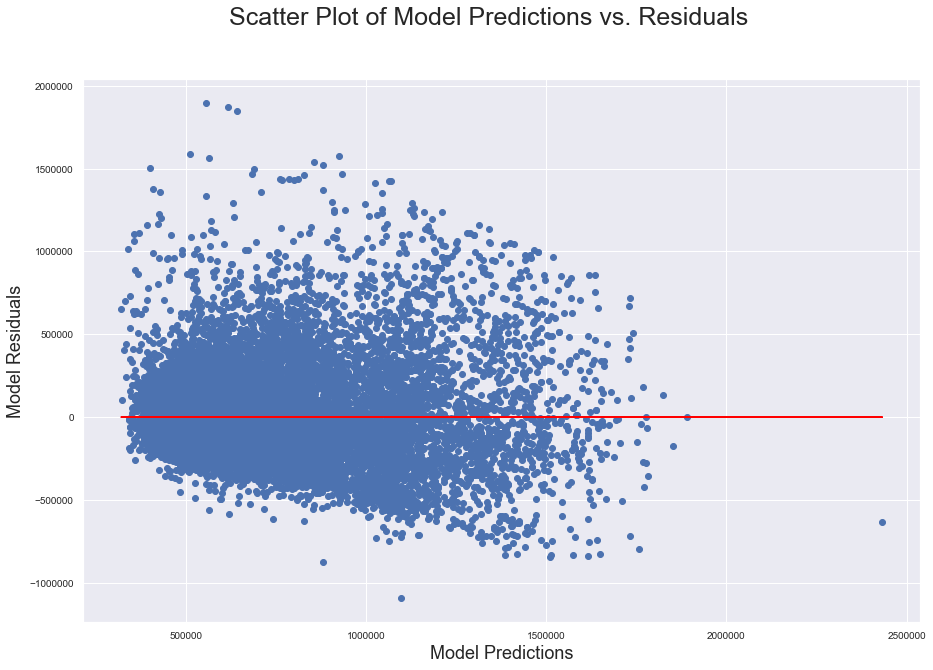

In [26]:
mf.homo_assumption(model12, df)

Much better!!  Adding building grades increased our R^2 quite significantly and also seemed to improve our assumptions a little better.  

In our next iteration, I'm interested in seeing if taking z-scores of all features in the model would improve anything (i'm thinking maybe not...)

# Model 13

In this iteration we model exactly the same as model 12 but with z-scores to be able to interpret the coefficients a little more easily.

In [27]:
features13 = ['saleprice',
              'squarefeettotalliving',
              'bathtotcount',
              'squarefeetdeck',
              'sqftporch',
              'bldgr_3',
              'bldgr_4',
              'bldgr_5',
              'bldgr_6',
              'bldgr_7',
              'bldgr_8',
              'bldgr_9',
              'bldgr_10',
              'bldgr_11','bldgr_12']

In [28]:
for feature in features13:
    mf.z_score(feature, df)
    
df.head()

,documentdate,saleprice,propertytype,principaluse,saleinstrument,currentuseland,historicproperty,salereason,propertyclass,zipcode,...,z_bldgr_3,z_bldgr_4,z_bldgr_5,z_bldgr_6,z_bldgr_7,z_bldgr_8,z_bldgr_9,z_bldgr_10,z_bldgr_11,z_bldgr_12
0,2019-04-01,1065000.0,12,6,3,N,N,1,8,98102.0,...,-0.01285,-0.032353,-0.106291,-0.32604,-0.820224,1.504967,-0.388321,-0.211638,-0.092149,-0.025707
1,2019-05-04,890000.0,12,6,3,N,N,1,8,98011.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
2,2019-11-05,640000.0,11,6,3,N,N,1,8,98125.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
3,2019-01-25,645000.0,11,6,3,N,N,1,8,98028.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
4,2019-10-05,907000.0,11,6,3,N,N,1,8,98005.0,...,-0.01285,-0.032353,-0.106291,-0.32604,-0.820224,1.504967,-0.388321,-0.211638,-0.092149,-0.025707


In [29]:
features13z = list(map(lambda x: 'z_' + x, features13))

In [30]:
model13 = mf.model(features13z, df, 'z_saleprice')

                            OLS Regression Results                            
Dep. Variable:            z_saleprice   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     1100.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:32:44   Log-Likelihood:                -20200.
No. Observations:               18170   AIC:                         4.043e+04
Df Residuals:                   18155   BIC:                         4.055e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

So we've stayed the same but we can compare coefficients a little more easily.  What is difficult to interpret is the coefficients of building grade - they're all negative, what does this mean exactly?  They make price go down?  

Ideas to investigate further:
- Do a bar plot of building grade mean sales prices to get an idea of what this data looks like
- Create a heatmap for these features

Next iteration:  `township` also has a highish correlation with sale price - look into what this variable is and maybe add it to the model.

In [31]:
x_features13 = ['squarefeettotalliving', 'bathtotcount',
              'squarefeetdeck',
              'sqftporch',
              'bldgr_3',
              'bldgr_4',
              'bldgr_5',
              'bldgr_6',
              'bldgr_7',
              'bldgr_8',
              'bldgr_9',
              'bldgr_10',
              'bldgr_11','bldgr_12']

Text(0.5, 1, 'Heat Map of Feature Multicollinearity')

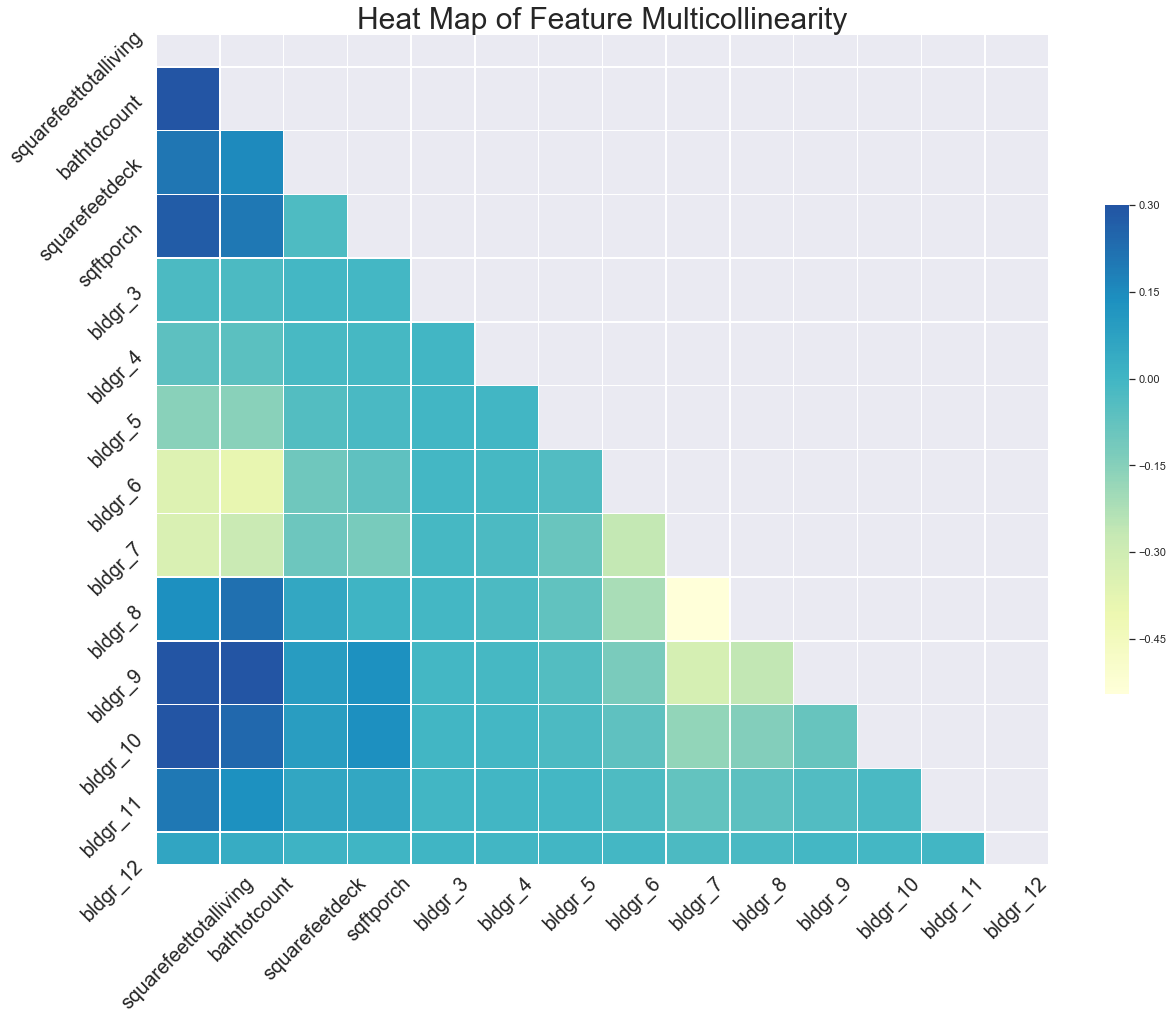

In [32]:
df_x_feats = df.loc[:, x_features13]

x_corrs = df_x_feats.corr()

mask = np.triu(np.ones_like(x_corrs, dtype=np.bool))
f, ax = plt.subplots(figsize = (20, 18))
sns.heatmap(x_corrs, mask = mask, cmap="YlGnBu", vmax = 0.3, 
            center = 0, square = True, linewidths = 0.5, 
            cbar_kws = {'shrink': 0.5})
ax.tick_params(axis='both', which='major', labelsize=20, labelrotation = 45)
ax.set_title('Heat Map of Feature Multicollinearity', fontsize = 30)

In [33]:
# a reminder of what these codes mean:
codes[codes['LUType'] == 82]['LUDescription']

1150    1  Cabin                                      ...
1151    10 Very Good                                  ...
1152    11 Excellent                                  ...
1153    12 Luxury                                     ...
1154    13 Mansion                                    ...
1155    2  Substandard                                ...
1156    Exceptional Properties                        ...
1157    3  Poor                                       ...
1158    4  Low                                        ...
1159    5  Fair                                       ...
1160    6  Low Average                                ...
1161    7  Average                                    ...
1162    8  Good                                       ...
1163    9  Better                                     ...
Name: LUDescription, dtype: object

In [34]:
# I can no longer inspect unique values of building grade because I dropped the column - maybe undo this move above so that we still have the original buildinggrade column

In [35]:
# We're not looking at cabins so we can probably remove cabins from our df

In [36]:
# maybe remove highly correlated building grades to see if this makes any improvement to the model...

In [37]:
# maybe drop 9 and/or 10

In [38]:
df.to_csv('../leana_m3')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18170 entries, 0 to 18169
Columns: 109 entries, documentdate to z_bldgr_12
dtypes: category(1), float64(47), int64(41), object(10), uint8(10)
memory usage: 13.8+ MB


In [40]:
df.head()

,documentdate,saleprice,propertytype,principaluse,saleinstrument,currentuseland,historicproperty,salereason,propertyclass,zipcode,...,z_bldgr_3,z_bldgr_4,z_bldgr_5,z_bldgr_6,z_bldgr_7,z_bldgr_8,z_bldgr_9,z_bldgr_10,z_bldgr_11,z_bldgr_12
0,2019-04-01,1065000.0,12,6,3,N,N,1,8,98102.0,...,-0.01285,-0.032353,-0.106291,-0.32604,-0.820224,1.504967,-0.388321,-0.211638,-0.092149,-0.025707
1,2019-05-04,890000.0,12,6,3,N,N,1,8,98011.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
2,2019-11-05,640000.0,11,6,3,N,N,1,8,98125.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
3,2019-01-25,645000.0,11,6,3,N,N,1,8,98028.0,...,-0.01285,-0.032353,-0.106291,-0.32604,1.219112,-0.664430,-0.388321,-0.211638,-0.092149,-0.025707
4,2019-10-05,907000.0,11,6,3,N,N,1,8,98005.0,...,-0.01285,-0.032353,-0.106291,-0.32604,-0.820224,1.504967,-0.388321,-0.211638,-0.092149,-0.025707
